In [7]:
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
import scienceplots
plt.style.use('science')

from exod.utils.path import data_combined
from exod.post_processing.crossmatch_simulation import split_subsets, crossmatch_simulation_subsets, get_subset_keys, get_unique_regions
import exod.post_processing.filter as filter
from exod.utils.plotting import plot_aitoff

from astropy.coordinates import match_coordinates_sky
from scipy.spatial import KDTree
from tqdm import tqdm
from scipy.stats import gaussian_kde
import cmasher
from exod.utils.plotting import set_latex_font
set_latex_font()

In [9]:
df_region_path = data_combined / 'merged_with_dr14/df_regions.csv'
df_regions = pd.read_csv(df_region_path)

# Filtering
#f1 = filter.FilterRegMultipleDetections('multiple_detections', n_obs=10)
#f2 = filter.FilterRegBright('max_intensity', max_intensity_mean=5000)
#f3 = filter.FilterRegArea('max_bbox', max_area_bbox=16)

# filters = [f2, f3]
# 
# print('Filtering:')
# for f in filters:
#     df_regions = f.apply(df_regions)
#     print(f.info())


# Cluster Unique
clustering_radius = 0.25 * u.arcsec
df_sources_unique = get_unique_regions(df_regions, clustering_radius)
df_sources_unique['count'].value_counts()

2024-06-28 12:06:44,542 - INFO - crossmatch_simulation.py:get_unique_regions - A total of 38648 unique sources were found from 60127 sources within a clustering radius of 0.25 arcsec


count
1    23500
2    11723
3     1666
4     1076
6      352
5      319
7       11
8        1
Name: count, dtype: int64

In [16]:
rs = np.concatenate([np.linspace(0,5,100), np.linspace(5, 50,100)])
cs = []
for r in tqdm(rs):
    df_sources_unique = get_unique_regions(df_regions, r*u.arcsec)
    cs.append(len(df_sources_unique))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.21it/s]


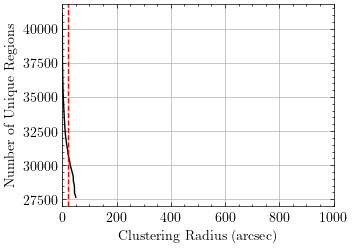

In [17]:
plt.figure()
plt.plot(rs, cs, color='black')
plt.xlabel('Clustering Radius (arcsec)')
plt.ylabel('Number of Unique Regions')
plt.xlim(0,1000)
plt.axvline(20, color='red', ls='dashed')

plt.grid()
#plt.savefig('../data/plots/cluster_radius_n_sources.png')
#plt.savefig('../data/plots/cluster_radius_n_sources.pdf')

plt.show()

In [3]:
subsets = get_subset_keys()
all_res = []
for i, r in tqdm(df_sources_unique.iterrows()):
    idxs = r['idxs']
    df_reg = df_regions.iloc[idxs]
    runids = df_reg['runid']
    res = {s:runids.str.contains(s).any() for s in subsets}
    all_res.append(res)

df_subsets = pd.DataFrame(all_res)
df_subsets

38648it [00:30, 1257.79it/s]


,5_0.2_2.0,5_2.0_12.0,5_0.2_12.0,50_0.2_2.0,50_2.0_12.0,50_0.2_12.0,200_0.2_2.0,200_2.0_12.0,200_0.2_12.0
0,True,False,False,False,False,False,False,False,False
1,True,False,True,False,False,False,False,False,False
2,True,False,True,False,False,False,False,False,False
3,True,False,True,False,False,False,False,False,False
4,True,False,True,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...
38643,False,False,False,False,False,False,False,False,True
38644,False,False,False,False,False,False,False,False,True
38645,False,False,False,False,False,False,False,False,True
38646,False,False,False,False,False,False,False,False,True


In [4]:
dfs_subsets = split_subsets(df_regions=df_regions)
dfs_subset_crossmatch = crossmatch_simulation_subsets(dfs_subsets=dfs_subsets)

2024-06-17 11:44:10,924 - INFO - crossmatch_simulation.py:split_subsets - Splitting df_regions into simulations subsets...
2024-06-17 11:44:11,760 - INFO - crossmatch_simulation.py:crossmatch_simulation_subsets - Matching 5_0.2_2.0 (10861) With 5_2.0_12.0   (959)
2024-06-17 11:44:11,829 - INFO - crossmatch_simulation.py:crossmatch_simulation_subsets - Matching 5_0.2_2.0 (10861) With 5_0.2_12.0   (12159)
2024-06-17 11:44:12,601 - INFO - crossmatch_simulation.py:crossmatch_simulation_subsets - Matching 5_0.2_2.0 (10861) With 50_0.2_2.0   (5843)
2024-06-17 11:44:12,945 - INFO - crossmatch_simulation.py:crossmatch_simulation_subsets - Matching 5_0.2_2.0 (10861) With 50_2.0_12.0  (1274)
2024-06-17 11:44:13,031 - INFO - crossmatch_simulation.py:crossmatch_simulation_subsets - Matching 5_0.2_2.0 (10861) With 50_0.2_12.0  (7142)
2024-06-17 11:44:13,453 - INFO - crossmatch_simulation.py:crossmatch_simulation_subsets - Matching 5_0.2_2.0 (10861) With 200_0.2_2.0  (6147)
2024-06-17 11:44:13,817 -

In [5]:
for k1, df1 in dfs_subset_crossmatch.items():
    for k2, df2 in dfs_subset_crossmatch.items():
        if k1 == k2:
            continue
        df1 = dfs_subset_crossmatch[k1]
        df2 = dfs_subset_crossmatch[k2]

        merge = df1.merge(df2, left_on=k1, right_on=k2)
        print(f'{k1:<15} {k2:<15} {len(merge)}')

5_0.2_2.0       5_2.0_12.0      959
5_0.2_2.0       5_0.2_12.0      10861
5_0.2_2.0       50_0.2_2.0      5843
5_0.2_2.0       50_2.0_12.0     1274
5_0.2_2.0       50_0.2_12.0     7142
5_0.2_2.0       200_0.2_2.0     6147
5_0.2_2.0       200_2.0_12.0    3431
5_0.2_2.0       200_0.2_12.0    10861
5_2.0_12.0      5_0.2_2.0       959
5_2.0_12.0      5_0.2_12.0      959
5_2.0_12.0      50_0.2_2.0      959
5_2.0_12.0      50_2.0_12.0     959
5_2.0_12.0      50_0.2_12.0     959
5_2.0_12.0      200_0.2_2.0     959
5_2.0_12.0      200_2.0_12.0    959
5_2.0_12.0      200_0.2_12.0    959
5_0.2_12.0      5_0.2_2.0       10861
5_0.2_12.0      5_2.0_12.0      959
5_0.2_12.0      50_0.2_2.0      5843
5_0.2_12.0      50_2.0_12.0     1274
5_0.2_12.0      50_0.2_12.0     7142
5_0.2_12.0      200_0.2_2.0     6147
5_0.2_12.0      200_2.0_12.0    3431
5_0.2_12.0      200_0.2_12.0    12159
50_0.2_2.0      5_0.2_2.0       5843
50_0.2_2.0      5_2.0_12.0      959
50_0.2_2.0      5_0.2_12.0      5843
50_0.2_2

In [6]:
k1 = '5_0.2_2.0'
k2 = '5_2.0_12.0'
df1 = dfs_subset_crossmatch[k1]
df2 = dfs_subset_crossmatch[k2]

df1.merge(df2, left_on=k1, right_on=k2)

,5_0.2_2.0_x,5_2.0_12.0_x,5_0.2_12.0_x,50_0.2_2.0_x,50_2.0_12.0_x,50_0.2_12.0_x,200_0.2_2.0_x,200_2.0_12.0_x,200_0.2_12.0_x,5_2.0_12.0_y,5_0.2_2.0_y,5_0.2_12.0_y,50_0.2_2.0_y,50_2.0_12.0_y,50_0.2_12.0_y,200_0.2_2.0_y,200_2.0_12.0_y,200_0.2_12.0_y
0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,7,-1,-1,-1,-1,-1,-1
1,1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2,2,-1,2,-1,-1,-1,-1,-1,-1,2,-1,28,-1,62,471,-1,1265,8817
3,3,-1,3,-1,-1,-1,-1,-1,-1,3,-1,50,-1,-1,-1,-1,-1,-1
4,4,-1,4,0,-1,1,0,-1,-1,4,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,954,-1,988,-1,-1,-1,-1,-1,-1,954,-1,12086,-1,-1,-1,-1,-1,-1
955,955,-1,990,-1,-1,-1,-1,-1,-1,955,-1,12108,-1,-1,-1,-1,-1,-1
956,956,-1,991,-1,-1,-1,-1,-1,-1,956,-1,-1,-1,-1,-1,-1,-1,-1
957,957,-1,-1,-1,-1,-1,-1,-1,-1,957,-1,-1,-1,-1,-1,-1,-1,-1


In [7]:
pd.concat([df_sources_unique, df_subsets], axis=1)

,ra_deg,dec_deg,idxs,count,5_0.2_2.0,5_2.0_12.0,5_0.2_12.0,50_0.2_2.0,50_2.0_12.0,50_0.2_12.0,200_0.2_2.0,200_2.0_12.0,200_0.2_12.0
0,9.801227,-43.825151,[0],1,True,False,False,False,False,False,False,False,False
1,9.739232,-43.775004,"[1, 7]",2,True,False,True,False,False,False,False,False,False
2,9.700222,-43.518297,"[2, 8]",2,True,False,True,False,False,False,False,False,False
3,9.476927,-43.551739,"[3, 9]",2,True,False,True,False,False,False,False,False,False
4,9.445900,-43.629838,"[4, 10, 13, 16, 18]",5,True,False,True,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38643,148.962088,69.679237,[60122],1,False,False,False,False,False,False,False,False,True
38644,149.018201,69.702035,[60123],1,False,False,False,False,False,False,False,False,True
38645,148.986061,69.707644,[60124],1,False,False,False,False,False,False,False,False,True
38646,148.889440,69.657460,[60125],1,False,False,False,False,False,False,False,False,True


In [ ]:
sub1 = result[result['runid'].str.contains('_5_')]
sub2 = result[result['runid'].str.contains('_50_')]
sub3 = result[result['runid'].str.contains('_200_')]

In [ ]:
sub3

In [ ]:
plt.figure(figsize=(4,3))
plt.hist(np.log10((sub1['n']/5)+1), bins=100, histtype='step', label=r'$t_{\mathrm{bin}}$ = 5')
plt.hist(np.log10((sub2['n']/50)+1), bins=100, histtype='step', label=r'$t_{\mathrm{bin}}$ = 50')
plt.hist(np.log10((sub3['n']/200)+1), bins=100, histtype='step', label=r'$t_{\mathrm{bin}}$ = 200')
plt.xlabel('Log Mean Observed Count Rate (ct / s)')
plt.ylabel('Number of Regions')
plt.legend()
plt.savefig('../data/plots/mean_observed_count_rate.png')
plt.savefig('../data/plots/mean_observed_count_rate.pdf')
plt.show()

In [ ]:
plt.figure()
for tbin in ['_5_', '_50_', '_200_']:
    for ebin in ['_0.2_12.0', '_0.2_2.0', '2.0_12.0']:
        sub = result[result['runid'].str.contains(tbin)]
        sub = sub[sub['runid'].str.contains(ebin)]
        v = int(tbin.split('_')[1])
        plt.hist(np.log10((sub['n']/v)+1), bins=100, histtype='step', label=f'sim{tbin} {ebin}')
#plt.yscale('log')
plt.legend()
    